# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

# Answers and Explainations


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import ExtraTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

In [2]:
#Load Data and take a peep
df = pd.read_csv("data/Euro_Salary.csv")
df.tail()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
1248,18/01/2021 15:05:50,31.0,Male,Berlin,Backend Developer,9,5,Senior,Java,"Python, Javascript / Typescript, Java / Scala,...",70000.0,72000,26,Full-time employee,Unlimited contract,English,51-100,Product
1249,18/01/2021 17:46:02,33.0,Male,Berlin,Researcher/ Consumer Insights Analyst,10,1.5,Senior,consumer analysis,NaN,60000.0,3000,unlimited,Full-time employee,Unlimited contract,English,1000+,Product
1250,18/01/2021 23:20:35,39.0,Male,Munich,IT Operations Manager,15,2,Lead,PHP,"Python, C/C++, Javascript / Typescript, Java /...",110000.0,0,28,Full-time employee,Unlimited contract,English,101-1000,eCommerce
1251,19/01/2021 10:17:58,26.0,Male,Saarbrücken,Frontend Developer,7,7,Middle,JavaScript,"Javascript / Typescript, Docker, HTML, CSS; Ad...",38350.0,40950,27,Full-time employee,Unlimited contract,German,101-1000,Product
1252,19/01/2021 12:01:11,26.0,Male,Berlin,DevOps,2,2,Middle,yaml,"Python, AWS, Kubernetes, Docker, terraform, an...",65000.0,6500,30,Full-time employee,Unlimited contract,English,51-100,Startup


### Data exploration and cleaning

We will begin by exploring and lookin at the data to see what the variables look like and whatr kind of cleaning is necessary to prepare the data for modeling.

From the initial exploration of the data with info() and describe() methods, we see that there are a total of 18 columns and 1253 rows of records. Of the 18 columns, only 3 columns have complete rows of records. This implies that we will need to do some dta imputation to fill the missing data.



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

1. We notice from the info() method that the dtypes of some of the columns do not accurately indicate the type of data that the columns hold. The first order of data cleaning will involve changing the data types of the following columns from 'object' to 'float64' to reflect that these columns contain numeric data:
    - Total years of experience
    - Years of experience in Germany 
    - Yearly bonus + stocks in EUR
    - Number of vacation days
    
To be able to effect this change, we need to understand that the reason why these columns were identified as 'object' in the first place is because there are some records in the data that do not conform to the float data type (possibly some text or some symbols). We therefore need to identify these records and handle them appropriately before we are able to transform the data type of the columns. The floatCheck function below will help us in identifying the records of each column that do not conform to the float type as we apply the function to each of the four columns. With this, we can then see what the issues are and thus determine how best to treat these.

One of the issues identified to be affecting some columns is the case where a comma (,) is used instead of a dot (.) to represent decimal numbers. We can easily fix this by replaciing all commas with dots. We will then use the numColumnClean() function to clean the other rows of data. Note that the function also does the job of filling in the missing data with zero. This is because we assume that values for these variables are not available, it is plausible that it is actually zero or some insignificant number.

In [3]:
# floatCheck function to identify if a record is a float type or not. Returns True or False
def floatCheck(x):
    try:
        float(x)
        return True
    except:
        return False

In [4]:
#Check the non-float records in Total years of experience 'tye_nf'
tye_nf = df['Total years of experience'][-df['Total years of experience'].apply(floatCheck)]
print(tye_nf, len(tye_nf))

#Change commas to dots This took care of 3 records
df['Total years of experience'] = df['Total years of experience'].apply(lambda x: x.replace(',', '.') if type(x) == str else x)

#Check the non-float records in Years of experience in Germany 'yeg_nf'
yeg_nf = df['Years of experience in Germany'][-df['Years of experience in Germany'].apply(floatCheck)]
print(yeg_nf, ':', len(yeg_nf))

#Change commas to dots. This took care of 17 records
df['Years of experience in Germany'] = df['Years of experience in Germany'].apply(lambda x: x.replace(',', '.') if type(x) == str else x)

#Check the non-float records in Yearly bonus + stocks in EUR 'yb_nf'
yb_nf = df['Yearly bonus + stocks in EUR'][-df['Yearly bonus + stocks in EUR'].apply(floatCheck)]
print(yb_nf, ':', len(yb_nf))

#Check the non-float records in Number of vacation days 'nvd_nf'
nvd_nf = df['Number of vacation days'][-df['Number of vacation days'].apply(floatCheck)]
print(nvd_nf, ':', len(nvd_nf))

486                                                   1,5
805                      1 (as QA Engineer) / 11 in total
834                                                   2,5
855                                  15, thereof 8 as CTO
1089    6 (not as a data scientist, but as a lab scien...
1192                                                  1,5
1209                                       less than year
Name: Total years of experience, dtype: object 7
100                                                   1,5
204                                                   4,5
263                                                   1,7
277                                                   3,5
311                                                   3,5
343                                                   < 1
392                    4 (in Switzerland), 0 (in Germany)
438                                                   1,5
486                                                   1,5
591                    

In [5]:
#numColumnClean function used to clean the identified non-conformities in the numerical data  
def numColumnClean(x):
    import re
    if pd.isna(x):         #This transforms all missing data to zero
        return '0'
    elif ('month' in x )| ('<' in x):       #Transforms experiences less than a year to zero
        return '0'
    elif 'unlimited' in x.lower():      #Transforms vacation days tagged as unlimited to 30 days
        return '30'
    elif not re.search(r'\d', x):
        return '0'
    elif re.search(r'\d+', x):
        return (re.search(r'\d+', x)).group()
    else:
        return x

In [6]:
columns_toFloat = ['Total years of experience', 'Years of experience in Germany', 'Yearly bonus + stocks in EUR', 'Number of vacation days']
df['Total years of experience'] = df['Total years of experience'].apply(numColumnClean)
df['Years of experience in Germany'] = df['Years of experience in Germany'].apply(numColumnClean)
df['Yearly bonus + stocks in EUR'] = df['Yearly bonus + stocks in EUR'].apply(numColumnClean)
df['Number of vacation days'] = df['Number of vacation days'].apply(numColumnClean)
df[columns_toFloat] = df[columns_toFloat].astype('float64')

In [11]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1253.0,NaN,NaN,NaN,8.925778,11.851049,0.0,5.0,8.0,12.0,383.0
Years of experience in Germany,1253.0,NaN,NaN,NaN,3.581804,3.657989,0.0,1.0,3.0,5.0,30.0
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.sample(20)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
1070,03/12/2020 11:04:39,28.0,Female,Berlin,Data Scientist,4.0,2.0,Middle,Python,Python,73700.0,80400.0,28.0,Full-time employee,Unlimited contract,English,1000+,Product
952,30/11/2020 12:45:00,34.0,Male,Berlin,Backend Developer,14.0,6.0,Lead,Kotlin,"Python, Kotlin, Java / Scala, SQL, AWS, Kubern...",96000.0,100000.0,29.0,Full-time employee,Unlimited contract,English,1000+,Startup
884,28/11/2020 07:10:16,33.0,Male,Berlin,Product Manager,5.0,5.0,Middle,PM tools,NaN,70000.0,0.0,26.0,Full-time employee,Temporary contract,English,1000+,Product
748,26/11/2020 09:50:38,25.0,Male,Berlin,Backend Developer,6.0,2.0,Senior,Go,"Python, SQL, Go, AWS, Kubernetes, Docker",86000.0,0.0,28.0,Full-time employee,Unlimited contract,English,101-1000,Startup
362,24/11/2020 18:22:41,40.0,Male,Frankfurt,Software Engineer,22.0,3.0,Senior,Java,"Kotlin, Javascript / Typescript, Java / Scala,...",72000.0,5000.0,30.0,Full-time employee,Unlimited contract,German,1000+,Product
447,24/11/2020 21:47:33,30.0,Male,Utrecht,Data Scientist,2.0,0.0,Middle,python,Google Cloud,48000.0,10000.0,25.0,Full-time employee,Temporary contract,English,1000+,Product
13,24/11/2020 11:18:26,34.0,Male,Berlin,Software Engineer,14.0,5.0,Senior,Typescript,"PHP, Javascript / Typescript, AWS",70000.0,0.0,28.0,Full-time employee,Unlimited contract,English,11-50,Startup
209,24/11/2020 13:09:38,26.0,Male,Berlin,Software Engineer,5.0,2.0,Middle,Scala,"Java / Scala, SQL, Google Cloud, Docker",63000.0,10300.0,28.0,Full-time employee,Unlimited contract,English,101-1000,Product
481,25/11/2020 07:56:59,30.0,Male,Munich,Software Engineer,10.0,4.0,Senior,.NET,"Python, Javascript / Typescript, Azure",75000.0,5000.0,30.0,Full-time employee,Unlimited contract,English,1000+,Product
866,27/11/2020 18:13:16,29.0,Female,Berlin,Software Engineer,4.0,4.0,Middle,Java/Kotlin,"Javascript / Typescript, SQL, AWS, Google Clou...",60000.0,15900.0,30.0,Full-time employee,Unlimited contract,English,101-1000,Consulting / Agency


2. We can also observe from the sample of data above that there are a couple of rows with null data in almost all their columns (index 181) For this dataset, we may assume that three variables are key which include Position, Yearly brutto salary (without bonus and stocks) in EUR and Company type. If a row does not contain these three information, then we may as well remove the rows. We will therefore isolate these rows, observe them, and decide what to do with them. However, we know that the column 'Yearly brutto salary (without bonus and stocks) in EUR' has all records complete. So we will focus on the two other columns

In [7]:
#Identify and drop rows with almost empty records
rows_toDrop = df[(df['Position '].isna()) & (df['Company type'].isna())]
rows_toDrop
df.drop(index=rows_toDrop.index, inplace=True)

In [8]:
#Create the calculated column "Total compensation"
df['Total Compensation'] = df['Yearly brutto salary (without bonus and stocks) in EUR'] + df['Yearly bonus + stocks in EUR']

#### Data Visualization

We will conduct some basic visualization of the data to see variable distribution and also to identify and treat possible outliers

1. Numeric data visualization using boxplot. From the boxplot as seen below, we see how the distribution for certain variables are skewed by outliers.
    - Total years of Experience has some data with value over 300 years.
    - "Years of experience in Germany" has some value that are greater than "Total years of experience". TRhis will be resolved by setting the Total years of experience to be equal to Years of Experience in Germany.
    - Yearly brutto salary (without bonus and stocks) in EUR has a row with excessively high value as well as for Yearly bonus + stocks in EUR and Total Compensation
    - Number of vacation days has some values that is above 60 days. 

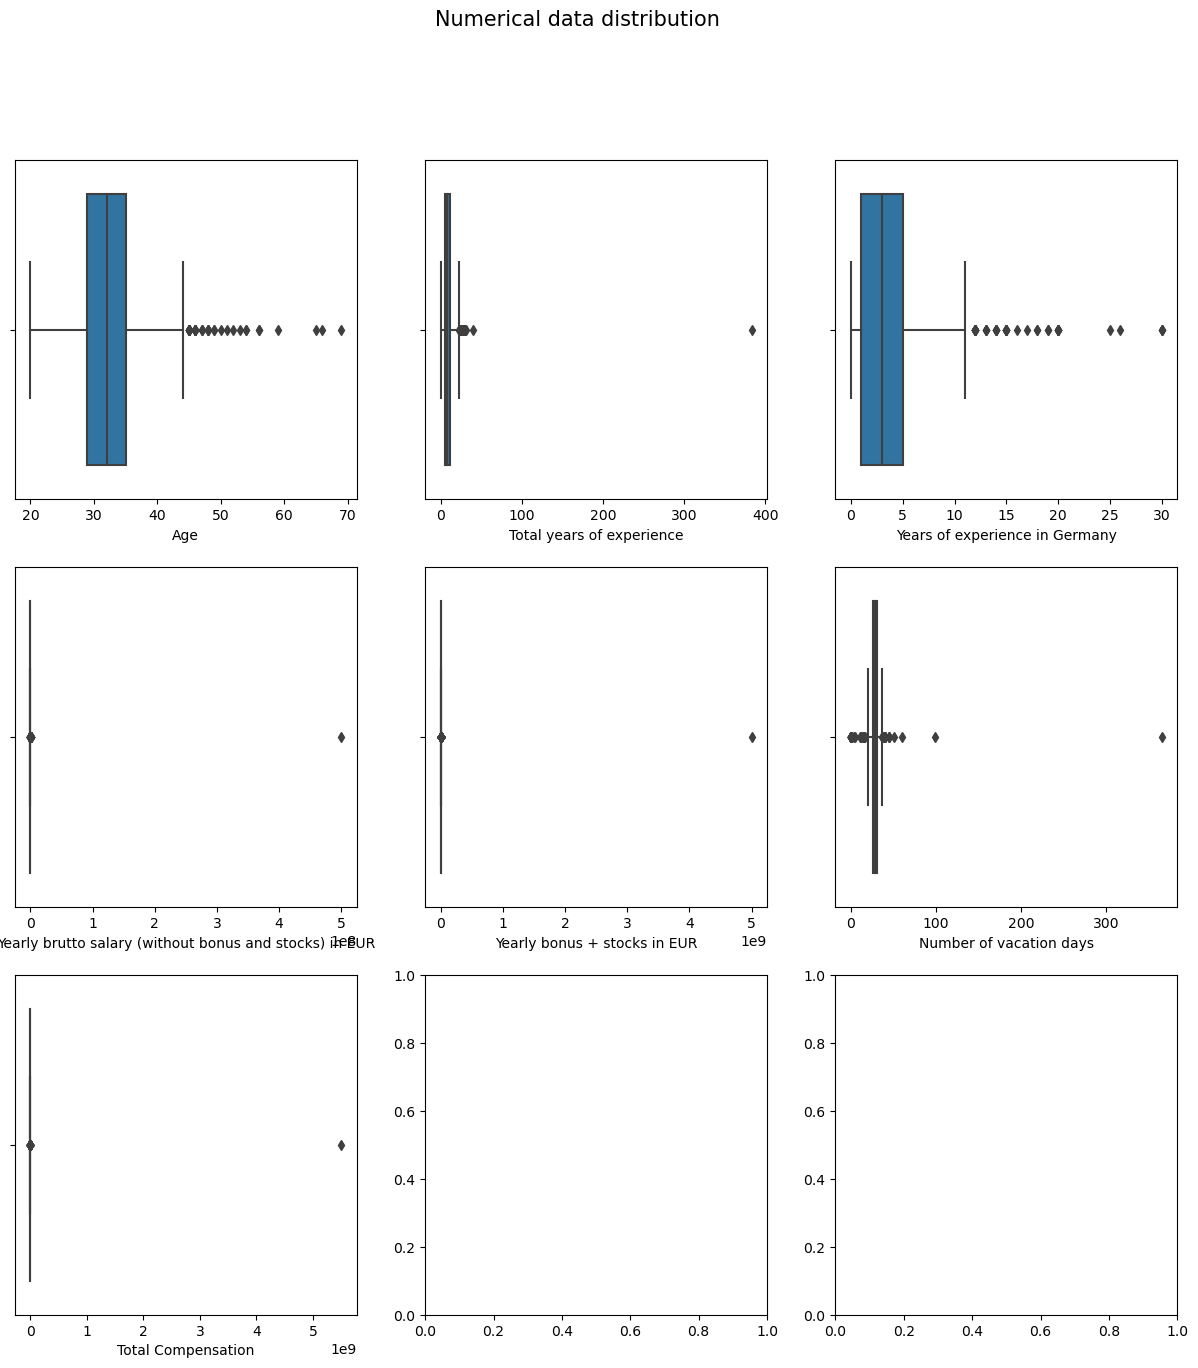

In [15]:
#Box plot for all numerical data in the dataset
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cols = 3
rows = math.ceil(len(num_cols)/cols)

fig, ax = plt.subplots(rows, cols, figsize=(15,15))
fig.suptitle("Numerical data distribution", fontsize=15)
r= 0
c= 0
for name in num_cols:
    sns.boxplot(data=df, x=name, ax=ax[r][c])
    c += 1
    if c == cols:
        r += 1
        c = 0

In [9]:
#Identify and drop some outliers
outlier1 = df[(df['Total years of experience'] > 40)|(df['Years of experience in Germany'] > 40)|(df['Number of vacation days'] > 60)]
df.drop(index=outlier1.index, inplace=True)

#Identify instances where Years of experience in Germany is greater than Total years of experience
outlier2 = df[df['Years of experience in Germany'] > df['Total years of experience']]

#Set the value of 'Total years of experience' in these rows to the value of 'Years of experience in Germany'
df['Total years of experience'][outlier2.index] = df['Years of experience in Germany'][outlier2.index]

C:\Users\adeni\AppData\Local\Temp\ipykernel_8376\2962354286.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total years of experience'][outlier2.index] = df['Years of experience in Germany'][outlier2.index]


2. Categorical Variable visualization. We use the countplot for initial visualization of the categorical variables.

From the countplots, we can see that some of the categories have a bunch of values with very small count. These variables will be handles by keeping the top most frequesnt categories with high counts, while grouping the rest into an 'Other' category. While most of the other categorical columns are transformed in some ways, there is no need to transform the Company size column.


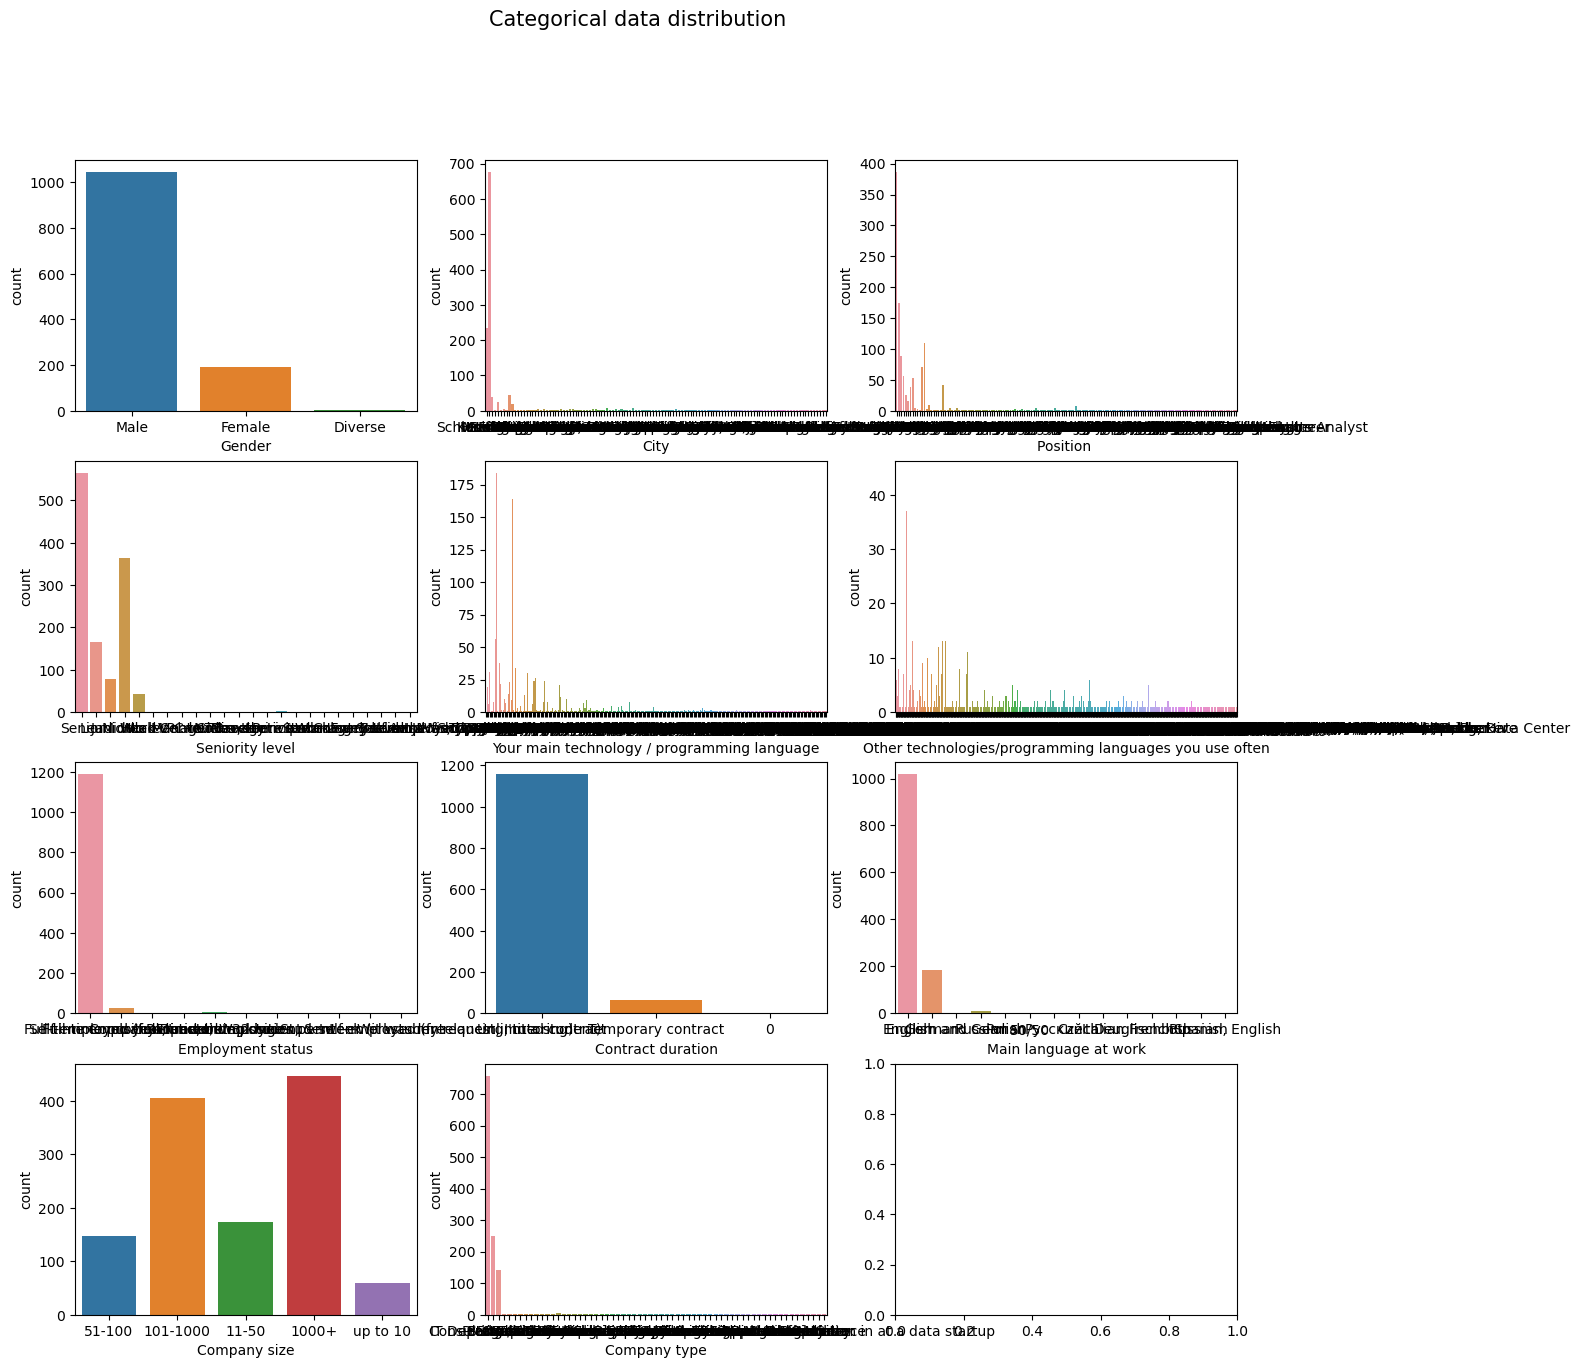

In [17]:
#Countplot for all categorical data in the dataset
cat_cols = df.select_dtypes(include=['object']).columns.to_list()
cols = 3
rows = math.ceil(len(cat_cols)/cols)

fig, ax = plt.subplots(rows, cols, figsize=(15,15))
fig.suptitle("Categorical data distribution", fontsize=15)
r= 0
c= 0
for name in cat_cols:
    sns.countplot(data=df, x=name, ax=ax[r][c])
    c += 1
    if c == cols:
        r += 1
        c = 0

In [10]:
#CATEGORICAL DATA CLEANING
#Convert the 'Diverse' category in Gender column to 'Male' category being the most frequent category in the record
df['Gender'].value_counts()
df['Gender'][df['Gender'] == 'Diverse'] = 'Male'

# Reform the city variable using a new category 'Other city' to represent cities with less than 19 records
df['City'].value_counts().head(20)
city_thresh = 19
low_city = df['City'].value_counts()[df['City'].value_counts() < city_thresh].index
df.loc[df['City'].isin(low_city), 'City'] = 'Other Cities'

# Reform the Position variable using a new category 'Other Position' to represent positions with less than 20 records
df['Position '].value_counts().head(20)
pos_thresh = 20
low_pos = df['Position '].value_counts()[df['Position '].value_counts() < pos_thresh].index
df.loc[df['Position '].isin(low_pos), 'Position '] = 'Other Positions'

# Reform the Seniority level variable using a new category 'Other levels' to represent Seniority level with less than 43 records
df['Seniority level'].value_counts()
sen_thresh = 43
low_sen = df['Seniority level'].value_counts()[df['Seniority level'].value_counts() < sen_thresh].index
df.loc[df['Seniority level'].isin(low_sen), 'Seniority level'] = 'Other levels'

# Reform the Employment status variable using a new category 'Other Status' to represent Employment status with less than 8 records
df['Employment status'].value_counts()
status_thresh = 8
low_status = df['Employment status'].value_counts()[df['Employment status'].value_counts() < status_thresh].index
df.loc[df['Employment status'].isin(low_status), 'Employment status'] = 'Other Status'

#Convert the '0' category in Сontract duration column to 'Temporary contract ' category because a person may likely say 0 when he has no contract or when the contract is temporary
df['Сontract duration'].value_counts()
df['Сontract duration'][df['Сontract duration'] == '0'] = 'Temporary contract'

# Reform the Main language at work variable using a new category 'Other Languages' to represent languages with less than 12 records
df['Main language at work'].value_counts()
lang_thresh = 12
low_lang = df['Main language at work'].value_counts()[df['Main language at work'].value_counts() < lang_thresh].index
df.loc[df['Main language at work'].isin(low_lang), 'Main language at work'] = 'Other Languages'

# Reform the Company type variable using a new category 'Other Types' to represent Company type with less than 141 records
df['Company type'].value_counts()
coy_thresh = 141
low_coy = df['Company type'].value_counts()[df['Company type'].value_counts() < coy_thresh].index
df.loc[df['Company type'].isin(low_coy), 'Company type'] = 'Other Types'

# convert all the data in the column to lower case string
df['Your main technology / programming language'] = df['Your main technology / programming language'].apply(lambda x: str(x).lower().strip() if not pd.isna(x) else x)
df['Your main technology / programming language'].value_counts().head(20)

top_n = 15
top_tech = df['Your main technology / programming language'].value_counts().nlargest(top_n).index
df.loc[~ df['Your main technology / programming language'].isin(top_tech), 'Your main technology / programming language'] = 'Other tech'

df.drop(columns={'Other technologies/programming languages you use often'}, inplace=True)


C:\Users\adeni\AppData\Local\Temp\ipykernel_8376\1213429715.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'][df['Gender'] == 'Diverse'] = 'Male'
C:\Users\adeni\AppData\Local\Temp\ipykernel_8376\1213429715.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Сontract duration'][df['Сontract duration'] == '0'] = 'Temporary contract'


### Data modeling

#### Modeling without feature selection

In [11]:
#Build pipeline/column transformer
num_features = ['Age', 'Total years of experience', 'Years of experience in Germany', 'Yearly brutto salary (without bonus and stocks) in EUR', 'Yearly bonus + stocks in EUR', 
                'Number of vacation days']
num_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
        ])

cat_features = ['Gender', 'City', 'Position ', 'Seniority level', 'Your main technology / programming language', 'Employment status', 'Сontract duration', 
                'Main language at work', 'Company size', 'Company type']
cat_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
        ])

preprocessor = ColumnTransformer( transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
        ])

#Let's set our features and target variable
y = df['Total Compensation']
X = df.drop(columns={'Total Compensation'})
print(y.shape, X.shape)

(1246,) (1246, 17)


In [18]:
#Make model with ExtraTreeRegressor
pipeline_steps = [('pre', preprocessor),('model', ExtraTreeRegressor(random_state=0) )]
pipe = Pipeline(pipeline_steps)

In [29]:
#Make predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Training Accuracy:', pipe.score(X_train, y_train))
print('Test Accuracy:', pipe.score(X_test, y_test))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))

Training Accuracy: 1.0
Test Accuracy: 0.9477441560346062
RMSE:  8450.494668936997


#### Modeling with hyperparameter changes/Grid Search improvements

In [30]:
#Grid search with hyperparameter tuning
params = {'model__criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
          'model__splitter':['random', 'best'],
          'model__max_depth':[3,4,5,6,7,8],
          'model__min_samples_split': [2,3,4,5,6,7,8],
          'model__ccp_alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
 
clf = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1) 
clf.fit(X_train, y_train.ravel())
best = clf.best_estimator_
print(best.score(X_test, y_test))
print(best)

#Best result was ExtraTreeRegressor(ccp_alpha=0.1, max_depth=8,min_samples_split=4, random_state=0,splitter='best')

0.9583283766404407
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Total years of experience',
                                                   'Years of experience in '
                                                   'Germany',
                                                   'Yearly brutto salary '
                                                   '(without bonus and stocks) '
                                                   'in EUR',
                                                   'Yearly bonus + stocks in '

In [32]:
#Make model with the identified hyper parameters
pipeline_steps = [('pre', preprocessor),('model', ExtraTreeRegressor(ccp_alpha=0.1, max_depth=8,min_samples_split=4, random_state=0,splitter='best'))]
pipe = Pipeline(pipeline_steps)
#Make predictions
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Training Accuracy:', pipe.score(X_train, y_train))
print('Test Accuracy:', pipe.score(X_test, y_test))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))

Training Accuracy: 0.9639256267032629
Test Accuracy: 0.9583283766404407
RMSE:  7546.314633265183


### Results
#### 1. Accuracy of models:

Without grid search using the default settings of the ExtraTreeRegressor, the average R2 score of the model was 
- Training Accuracy: 1.0
- Test Accuracy: 0.9477441560346062
- RMSE:  8450.494668936997

After the grid search, the best model was identified as ExtraTreeRegressor(ccp_alpha=0.1, max_depth=8,min_samples_split=4, random_state=0,splitter='best') with a result of:
- Training Accuracy: 0.9639256267032629
- Test Accuracy: 0.9583283766404407
- RMSE:  7546.314633265183
### Feature Selection Activities

### Hyperparameter Changes